<img align="left" src="imgs/logo.jpg" width="50px" style="margin-right:10px">
# Snorkel Workshop: Extracting Spouse Relations <br> from the News
## Part 3: Training the Generative Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re
import numpy as np

# Connect to the database backend and initalize a Snorkel session
from lib.init import *
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels

from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

# I. Loading Labeling Matricies 

First we'll load our label matrices from notebook 2

In [2]:
from snorkel.annotations import LabelAnnotator

labeler = LabelAnnotator()
L_train = labeler.load_matrix(session, split=0)
L_dev   = labeler.load_matrix(session, split=1)

Now we set up and run the hyperparameter search, training our model with different hyperparamters and picking the best model configuration to keep. We'll set the random seed to maintain reproducibility.

Note that we are fitting our model's parameters to the training set generated by our labeling functions, while we are picking hyperparamters with respect to score over the development set labels which we created by hand.

# II: Unifying supervision

## A. Majority Vote
The most simple way to unify the output of all your LFs is by computed the _unweighted majority vote_. 

In [3]:
from lib.scoring import *

majority_vote_score(L_dev, L_gold_dev)

pos/neg    190:2621 6.8%/93.2%
precision  42.65
recall     30.53
f1         35.58


## B. Generative Model
In data programming, we use a more sophisitcated model to unify our labeling functions. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a generative model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which we will then use to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NIPS 2016 paper](https://arxiv.org/abs/1605.07723).

### 1. Training the Model
When training the generative model, we'll tune our hyperparamters using a simple grid search. 

**Parameter Definitions**
    
    epochs     A single pass through all the data in your training set
    step_size  The factor by which we update model weights after computing the gradient
    decay      The rate our update factor dimishes (decay) over time.
    

In [11]:
from snorkel.learning import GenerativeModel
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

# use grid search to optimize the generative model
step_size_param     = ListParameter('step_size', [0.1 / L_train.shape[0], 1e-5])
decay_param         = ListParameter('decay', [0.9, 0.95])
epochs_param        = ListParameter('epochs', [10, 50])
reg_param           = ListParameter('reg_param', [1e-3, 1e-6])
prior_param         = ListParameter('LF_acc_prior_weight_default', [1.0, 0.9, 0.8])


# search for the best model
param_grid = [step_size_param, decay_param, epochs_param, reg_param, prior_param]
searcher = RandomSearch(GenerativeModel, param_grid, L_train, n=10, lf_propensity=False)
%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev, deps=set())

run_stats

Initialized RandomSearch search of size 10. Search space size = 48.
[1] Testing step_size = 4.49e-06, decay = 9.00e-01, epochs = 50, reg_param = 1.00e-03, LF_acc_prior_weight_default = 8.00e-01
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.413994169096
[GenerativeModel] Model saved as <GenerativeModel_0>.
[2] Testing step_size = 1.00e-05, decay = 9.00e-01, epochs = 50, reg_param = 1.00e-03, LF_acc_prior_weight_default = 9.00e-01
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.360856269113
[3] Testing step_size = 1.00e-05, decay = 9.50e-01, epochs = 50, reg_param = 1.00e-06, LF_acc_prior_weight_default = 9.00e-01
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.355828220859
[4] Testing step_size = 1.00e-05, decay = 9.50e-01, epochs = 50, reg_param = 1.00e-03, LF_acc_prior_weight_default = 1.00e+00
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.355828220859
[5] Testing step_size = 4.49e-06, decay = 9.50e-01, epochs = 10, reg_param = 1.00e-06, LF_acc_prior_weight

,step_size,decay,epochs,reg_param,LF_acc_prior_weight_default,Prec.,Rec.,F1
0,0.000004,0.90,50,0.001000,0.8,0.464052,0.373684,0.413994
4,0.000004,0.95,10,0.000001,0.8,0.464052,0.373684,0.413994
5,0.000004,0.95,10,0.000001,0.8,0.464052,0.373684,0.413994
7,0.000004,0.95,50,0.000001,1.0,0.464052,0.373684,0.413994
1,0.000010,0.90,50,0.001000,0.9,0.430657,0.310526,0.360856
6,0.000010,0.90,50,0.001000,0.8,0.430657,0.310526,0.360856
2,0.000010,0.95,50,0.000001,0.9,0.426471,0.305263,0.355828
3,0.000010,0.95,50,0.001000,1.0,0.426471,0.305263,0.355828
8,0.000010,0.95,50,0.001000,0.9,0.426471,0.305263,0.355828
9,0.000010,0.95,50,0.001000,0.9,0.426471,0.305263,0.355828


### 2. Model Accuracies
These are the weights learned for each LF

In [12]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_TERMS_marriage_[between|words]_TRUE,0,0.071861,0.027037,0.027037,64,129,0,0,0.331606,0.515712
LF_DIST_SUPERVISION_dbpedia_TRUE,1,0.009249,0.009249,0.009249,22,4,0,0,0.846154,0.501877
LF_TERMS_almost_married_[between|words]_FALSE,2,0.012451,0.004980,0.002846,0,0,7,24,0.774194,0.498272
LF_kb_and_marriage,3,0.003557,0.003557,0.003557,10,0,0,0,1.000000,0.504446
LF_contrarian,4,0.009249,0.009249,0.009249,0,0,22,4,0.153846,0.509825
LF_TERMS_almost_married_[left|words|window=1]_FALSE,5,0.004625,0.004625,0.001067,0,0,0,13,1.000000,0.503472
LF_TERMS_almost_married_[left|words|window=2]_FALSE,6,0.004980,0.004980,0.001067,0,0,0,14,1.000000,0.501639
LF_TERMS_almost_married_[left|words|window=3]_FALSE,7,0.006403,0.006403,0.001067,0,0,0,18,1.000000,0.499328
LF_TERMS_almost_married_[left|words|window=4]_FALSE,8,0.006403,0.006403,0.001067,0,0,0,18,1.000000,0.503309
LF_too_far_apart,9,0.179651,0.024902,0.022768,0,0,22,465,0.954825,0.503053


In [13]:
train_marginals = gen_model.marginals(L_train)

### 3. Plotting Marginal Probabilities
One immediate santity check  you can peform using the generative model is to visually examine the distribution of predicted training marginals. Ideally, there should get a bimodal distribution with large seperation between each peaks.

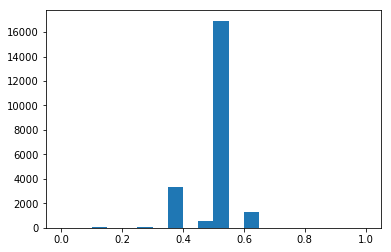

In [14]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20, range=(0.0, 1.0))
plt.show()

### 4. Generative Model Metrics

In [15]:
dev_marginals = gen_model.marginals(L_dev)
_, _, _, _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.374
Neg. class accuracy: 0.969
Precision            0.464
Recall               0.374
F1                   0.414
----------------------------------------
TP: 71 | FP: 82 | TN: 2539 | FN: 119



### 5. Saving our training labels

Finally, we'll save the `training_marginals`, which are our **"noise-aware training labels"**, so that we can use them in the next tutorial to train our end extraction model:

In [16]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 22254 marginals
CPU times: user 14.4 s, sys: 956 ms, total: 15.3 s
Wall time: 21.9 s


# III. Advanced Generative Model Features

## A. Structure Learning

We may also want to include the dependencies between our LFs when training the generative model. Snorkel makes it easy to do this! `DependencySelector` runs a fast structure learning algorithm over the matrix of LF outputs to identify a set of likely dependencies. 

In [ ]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
print len(deps)

Now train the generative model with dependencies, we just pass in the above set as the `deps` argument to our model train function.

    searcher = RandomSearch(GenerativeModel, param_grid, L_train, n=4, lf_propensity=False)
    gen_model, run_stats = searcher.fit(L_dev, L_gold_dev, deps=deps)
    run_stats